In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
    
# ! Defines the GridWorld environment (states, actions, transition function)
class GridWorld:
    """Making a GridWorld object to make different grid size custom environments to mimic Fronze Lake"""

    def __init__(self, size=4, time_step_cost=-0.01):
        """Setting up main parts of the Grid environment

        Args:
            size (4, optional): square grid side length. Defaults to 4.
        """
        self.size = size  # - square grid size
        self.nS = size * size  # - number of states
        self.nA = 4  # - number of actions
        self.time_step_cost = time_step_cost  # - cost for each time step
        
        self.UP, self.DOWN, self.LEFT, self.RIGHT = range(4)
        
        self.goal = set(np.random.choice(range(1, self.nS), size=self.size // 4, replace=False)) # - goals
        self.holes = set(np.random.choice(range(1, self.nS), size=self.size // 2, replace=False)) # - holes

        self.P = self.build_transition_table()  # - the MDP

    def build_transition_table(self):
        """Creating the transition function using a function and loops rather than writing a large dictionary by hand"""
        P = {
            s: {a: [] for a in range(self.nA)} for s in range(self.nS)
        }  # ^ P[state][action] = []

        for s in range(self.nS):  # * setting transitions for every state
            row, col = divmod(
                s, self.size
            )  # ? divmod(a, b) -> (a // b, a % b), this maps index to grid position
            #           state 6 in 4x4 grid
            #           6 // 4 = 1  (row)
            #           6 % 4  = 2  (col)

            for a in range(self.nA):

                if (
                    s in self.goal or s in self.holes
                ):  # * if state is already at goal or hole, loop back to itself with 0 reward
                    
                    P[s][a].append(
                        (1.0, s, 0, True)
                    )  # ? (1.0, s, 0, True) -> (probability, next_state, reward, done)

                    continue
                
                new_row, new_col = (
                    row,
                    col,
                )  # * assume we don't move to start, then update position based on action

                # ! movement logic along with boundary checks
                if (
                    a == self.UP
                ):  # ^ up one row, but max() prevents us from going out of bounds (negative row index)
                    new_row = max(row - 1, 0)
                elif (
                    a == self.DOWN
                ):  # ^ down one row, but min() prevents us from going out of bounds (exceeding row index)
                    new_row = min(row + 1, self.size - 1)
                elif (
                    a == self.LEFT
                ):  # ^ left one column, but max() prevents us from going out of bounds (negative column index)
                    new_col = max(col - 1, 0)
                elif (
                    a == self.RIGHT
                ):  # ^ right one column, but min() prevents us from going out of bounds (exceeding column index)
                    new_col = min(col + 1, self.size - 1)

                ns = (
                    new_row * self.size + new_col
                )  # - ns -> new state index after movement
                # ? (1,2) → 1*4 + 2 = 6 -> math for ns

                reward = self.time_step_cost  # - time cost
                done = False  # - default done is False, is True when we hit a hole or the goal

                if (
                    ns in self.holes
                ):  # * hole is bad (reward = -1) and ends episode (done = True)
                    reward = -1
                    done = True

                if (
                    ns in self.goal
                ):  # * goal is good (reward = 1) and ends episode (done = True)
                    reward = 1
                    done = True

                P[s][a].append((1.0, ns, reward, done))  # ? P(s′∣s,a) = 1

        return P  # * returns the full transition table for the MDP
        # ^ this transition function is deterministic
        # ^ each action has 1.0 probability of leading to the next state
        # ^ not slippery, yet



In [3]:

# ! creates the optimal value function for the MDP (value iteration algorithm)
def value_iteration(env, gamma=0.99, theta=1e-6):
    """Value Iteration algorithm to solve the MDP

    Args:
        env (GridWorld): The GridWorld environment instance
        gamma (float, optional): Discount factor. Defaults to 0.99.
        theta (float, optional): Convergence threshold. Defaults to 1e-6.

    Returns:
        V (numpy array): Optimal value function
    """

    V = np.zeros(env.nS)  # - initialize value function

    while True:
        delta = 0  # - to track max change in value function
        
        for s in range(env.nS):  # * for each state
            values = []

            for a in range(env.nA):  # * for each action
                total = 0
                
                for p, ns, r, _ in env.P[s][
                    a
                ]:  # * for each possible outcome of action a in state s
                    total += p * (
                        r + gamma * V[ns]
                    )  # - Bellman update for value iteration
                    # ? Bellman equation -> r + γV(s′)
                values.append(total)  # * store the value for action a
            
            best = max(values)  # * best action value
            delta = max(delta, abs(V[s] - best))  # * update delta with max change
            V[s] = best  # * update value function for state s
        
        if delta < theta:  # * check for convergence
            break
    
    return V  # * return the optimal value function

In [4]:

# ! Extracts the optimal policy from the optimal value function
def extract_policy(env, V, gamma=0.99):
    """Extract the optimal policy from the optimal value function
    
    Args:
        env (GridWorld): The GridWorld environment instance
        V (numpy array): Optimal value function
        gamma (float, optional): Discount factor. Defaults to 0.99.
    
    Returns:
        policy (numpy array): Optimal policy
    """

    policy = np.zeros(env.nS, dtype=int)

    for s in range(env.nS):  # * for each state
        action_values = []

        for a in range(env.nA):  # * for each action
            total = 0

            for p, ns, r, _ in env.P[s][
                a
            ]:  # * for each possible outcome of action a in state s
                total += p * (r + gamma * V[ns])
            action_values.append(total)

        policy[s] = np.argmax(
            action_values
        )  # * returns the index for which action has the highest value for a state
    
    return policy


In [5]:

# ! This is visualization of the MDP and optimal policy
from matplotlib.patches import Rectangle

def render_policy(env, policy):
    """Visualization of the GridWorld environment
    
    Args:
        env (GridWorld): The GridWorld environment instance
        policy (numpy array): Optimal policy
    """
    arrows = ["↑", "↓", "←", "→"]
    
    for s in range(env.nS):
        if s in env.holes:
            print(" H ", end="")
        elif s in env.goal:
            print(" G ", end="")
        else:
            print(f" {arrows[policy[s]]} ", end="")
        
        if (s + 1) % env.size == 0:
            print()


def render_policy_image(env, policy):
    """Render the policy as a graphical image using matplotlib."""
    
    size = env.size
    fig, ax = plt.subplots(figsize=(size, size))
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_xticks(np.arange(0, size+1, 1))
    ax.set_yticks(np.arange(0, size+1, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True)
    ax.set_aspect('equal')
    
    # Draw holes and goal
    for s in range(env.nS):
        row, col = divmod(s, size)
        if s in env.holes:
            ax.add_patch(Rectangle((col, size-1-row), 1, 1, color='black'))
        elif s in env.goal:
            ax.add_patch(Rectangle((col, size-1-row), 1, 1, color='gold'))
    
    # Draw arrows for policy
    arrow_dict = {
        0: (0, 0.2, 0, 0.2),   # UP
        1: (0, -0.2, 0, -0.2), # DOWN
        2: (-0.2, 0, -0.2, 0), # LEFT
        3: (0.2, 0, 0.2, 0),   # RIGHT
    }
    for s in range(env.nS):
        if s in env.holes or s in env.goal:
            continue
        row, col = divmod(s, size)
        a = policy[s]
        dx1, dy1, dx2, dy2 = arrow_dict[a]
        ax.arrow(col+0.5, size-1-row+0.5, dx1, dy1, head_width=0.2, head_length=0.2, fc='blue', ec='blue')
    
    # Draw grid lines
    for i in range(size+1):
        ax.axhline(i, color='gray', linewidth=0.5)
        ax.axvline(i, color='gray', linewidth=0.5)
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='black', edgecolor='black', label='Hole'),
        Patch(facecolor='gold', edgecolor='gold', label='Goal'),
        Patch(facecolor='white', edgecolor='black', label='Normal State')
    ]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Show plot
    plt.title('Optimal Policy')
    plt.tight_layout(rect=(0, 0, 1, 1))
    plt.show()

Value function:
 [[0.9019801  0.92119202 0.940598   0.9602     0.940598   0.92119202
  0.92119202 0.9019801 ]
 [0.92119202 0.940598   0.9602     0.98       0.9602     0.940598
  0.940598   0.92119202]
 [0.940598   0.9602     0.98       1.         0.98       0.9602
  0.9602     0.        ]
 [0.9602     0.98       1.         0.         1.         0.98
  0.98       1.        ]
 [0.940598   0.         0.98       1.         0.98       0.98
  1.         0.        ]
 [0.92119202 0.940598   0.9602     0.98       0.9602     0.9602
  0.98       1.        ]
 [0.9019801  0.92119202 0.         0.9602     0.940598   0.940598
  0.9602     0.98      ]
 [0.8829603  0.9019801  0.92119202 0.940598   0.92119202 0.
  0.940598   0.9602    ]]

Optimal policy:
 ↓  ↓  ↓  ↓  ↓  ↓  ↓  ↓ 
 ↓  ↓  ↓  ↓  ↓  ↓  ↓  ← 
 ↓  ↓  ↓  ↓  ↓  ↓  ↓  H 
 →  →  →  G  ←  ←  ↓  ↓ 
 ↑  H  ↑  ↑  ↑  →  →  G 
 ↑  →  ↑  ↑  ↑  ↑  ↑  ↑ 
 ↑  ↑  H  ↑  ↑  ↑  ↑  ↑ 
 ↑  ↑  →  ↑  ↑  H  ↑  ↑ 


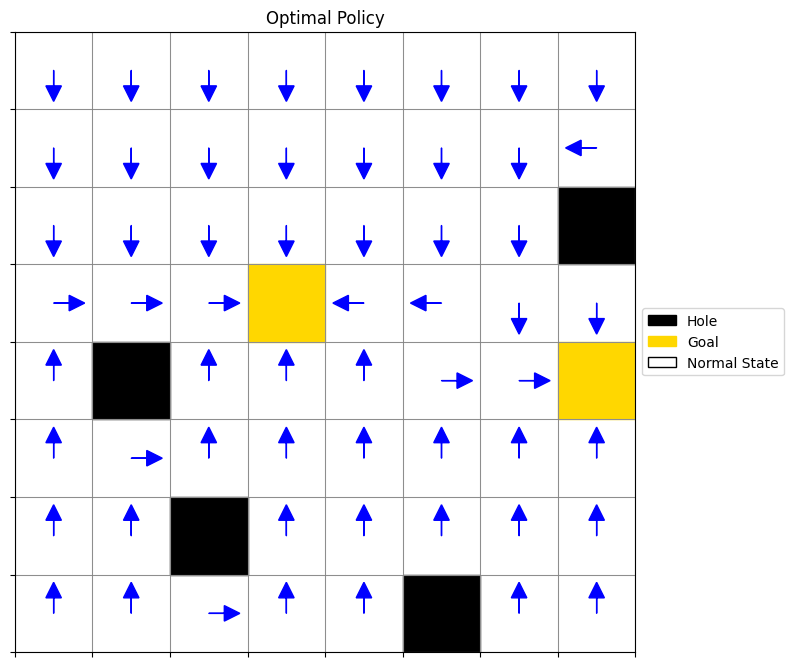

In [29]:
if __name__ == "__main__":
    env = GridWorld(size=8, time_step_cost=-0.01)
    
    V = value_iteration(env)
    policy = extract_policy(env, V)
    
    print("Value function:\n", V.reshape(env.size, env.size)) # * reshape value function to match grid layout for better visualization
    print("\nOptimal policy:") # * print the optimal policy in a grid format using arrows to indicate actions
    
    render_policy(env, policy)
    render_policy_image(env, policy)